C:\Users\Jcp45\AppData\Local\Temp\ipykernel_21024\1704631994.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.fillna(features.mean(), inplace=True)


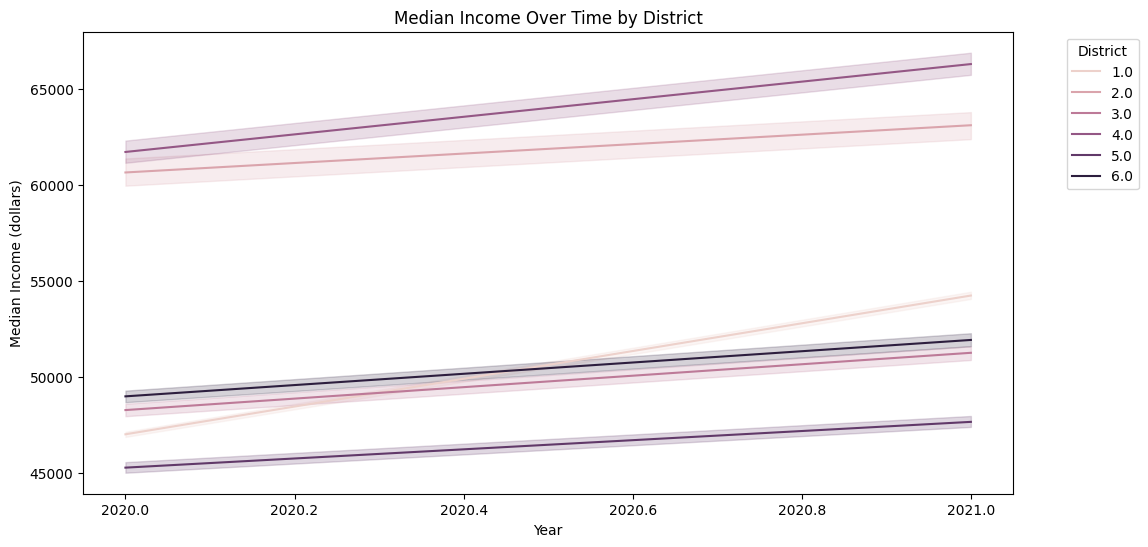

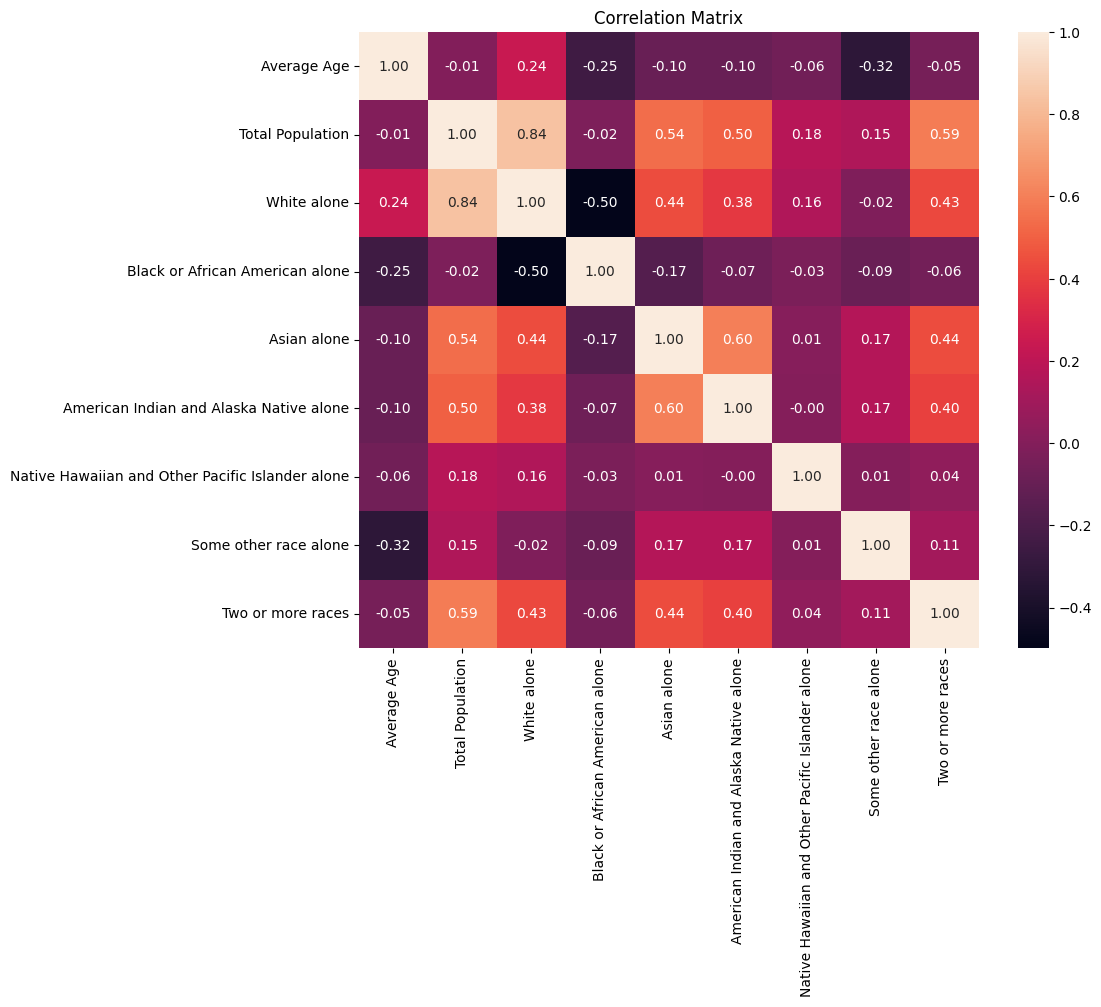

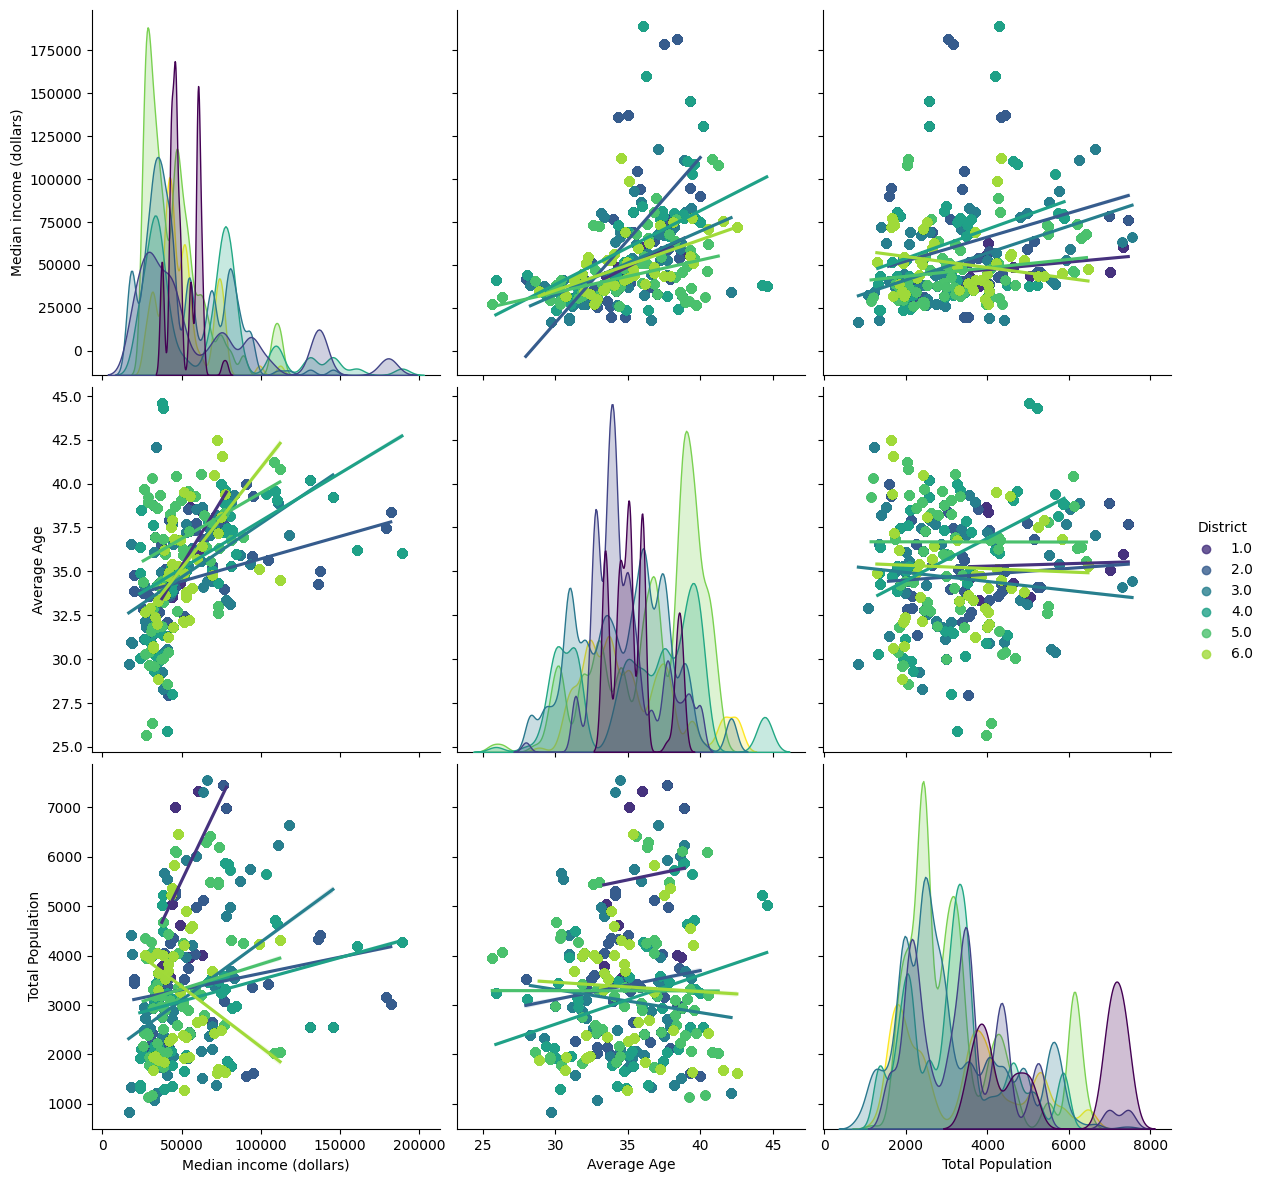

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# Load the datasets
census_data = pd.read_csv('Census total.csv', low_memory=False)
district_data = pd.read_csv('updated_districts_cleaned.csv', low_memory=False)

# Ensure 'Census Tract' column is a string in both datasets
census_data['Census Tract'] = census_data['Census Tract'].astype(str)
district_data['Census Tract'] = district_data['Census Tract'].astype(str)

# Convert 'year' column to integer
census_data['year'] = pd.to_numeric(census_data['year'], errors='coerce').astype('Int64')

# Check if 'Old District' exists in district_data
if 'Old District' not in district_data.columns:
    raise ValueError("Column 'Old District' not found in district_data")

# Splitting the census data based on the year
pre_2020_data = census_data[census_data['year'] < 2020]
post_2020_data = census_data[census_data['year'] >= 2020]

# Merging the pre-2020 data with old district information
pre_2020_data = pd.merge(pre_2020_data, district_data[['Census Tract', 'Old District']], 
                         on='Census Tract', how='left')

# Merging the 2020-2021 data with new district information
post_2020_data = pd.merge(post_2020_data, district_data[['Census Tract', 'new district']], 
                          on='Census Tract', how='left')
post_2020_data.rename(columns={'new district': 'District'}, inplace=True)

# Combine the datasets
combined_data = pd.concat([pre_2020_data, post_2020_data])

# Add a column to indicate if the district has changed
combined_data['District Changed'] = combined_data['Old District'] != combined_data['District']



# Convert 'Median income (dollars)' to numeric
combined_data['Median income (dollars)'] = pd.to_numeric(combined_data['Median income (dollars)'], errors='coerce')

# Define and process race columns
race_columns = ['White alone', 'Black or African American alone', 'Asian alone', 
                'American Indian and Alaska Native alone', 'Native Hawaiian and Other Pacific Islander alone', 
                'Some other race alone', 'Two or more races']
for col in race_columns:
    combined_data[col] = pd.to_numeric(combined_data[col], errors='coerce').fillna(0)

# Define age midpoints and calculate average age
age_midpoints = {'Under 5 years': 2.5, '5 to 9 years': 7.5, '10 to 14 years': 12.5, '15 to 19 years': 17.5, 
                 '20 to 24 years': 22.5, '25 to 29 years': 27.5, '30 to 34 years': 32.5, '35 to 39 years': 37.5, 
                 '40 to 44 years': 42.5, '45 to 49 years': 47.5, '50 to 54 years': 52.5, '55 to 59 years': 57.5, 
                 '60 to 64 years': 62.5, '65 to 69 years': 67.5, '70 to 74 years': 72.5, '75 to 79 years': 77.5, 
                 '80 to 84 years': 82.5}
for age_group in age_midpoints:
    if age_group in combined_data.columns:
        combined_data[age_group] = pd.to_numeric(combined_data[age_group], errors='coerce').fillna(0)
combined_data['Total years'] = sum(combined_data[col] * age_midpoints[col] for col in age_midpoints if col in combined_data.columns)
combined_data['Total Population'] = combined_data[[col for col in age_midpoints]].sum(axis=1)
combined_data['Average Age'] = combined_data['Total years'] / combined_data['Total Population']
#variables
feature_columns = ['Average Age', 'Total Population'] + race_columns
features = combined_data[feature_columns]
target = combined_data['Median income (dollars)']

# Handle missing values in features and target
features.fillna(features.mean(), inplace=True)
target.fillna(target.mean(), inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize AdaBoost Regressor
ada_boost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                              n_estimators=100, random_state=42)

# Train the model
ada_boost.fit(X_train, y_train)

# Make predictions
y_pred = ada_boost.predict(X_test)


plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_data, x='year', y='Median income (dollars)', hue='District')
plt.title('Median Income Over Time by District')
plt.xlabel('Year')
plt.ylabel('Median Income (dollars)')
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
combined_data['District Changed'] = combined_data['Old District'] != combined_data['District']


plt.figure(figsize=(10, 8))
sns.heatmap(combined_data[feature_columns].corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

pairplot_columns = ['Median income (dollars)', 'Average Age', 'Total Population', 'District']
sns.pairplot(combined_data[pairplot_columns].dropna(), 
             hue='District', 
             height=4, 
             aspect=1, 
             diag_kind='kde', 
             kind='reg', 
             palette='viridis',
             plot_kws={}, 
             diag_kws={'fill': True})  
plt.show()
